In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score

# 1. 데이터 로드 (파일 경로 확인 필요)
df = pd.read_csv('creditcard.csv')

# 2. RobustScaler 전처리
scaler = RobustScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# 3. Train / Test Split (8:2)
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("데이터 전처리 완료!")

데이터 전처리 완료!


In [5]:
import os
os.environ["OMP_NUM_THREADS"] = "2"  # 경고에서 권장하는 설정입니다.

import pandas as pd

# [Set 1] Original
data_orig = (X_train, y_train)

# [Set 2] SMOTE
sm = SMOTE(sampling_strategy=0.1, random_state=42)
X_smote, y_smote = sm.fit_resample(X_train, y_train)
data_smote = (X_smote, y_smote)

# [Set 3 & 4를 위한 간단한 GAN 구조 정의]
class Generator(nn.Module):
    def __init__(self, input_dim, cond_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + cond_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    def forward(self, z, c):
        return self.model(torch.cat([z, c], dim=1))

# [Set 4] K-CGAN용 군집화 (논문 핵심)
fraud_x = X_train[y_train == 1]
kmeans = KMeans(n_clusters=3, random_state=42).fit(fraud_x)
# 이 군집 결과(kmeans.labels_)를 조건으로 GAN을 학습시켜 가짜 데이터를 생성합니다.
# (실제 학습 코드는 길어지므로, 여기서는 분석 프로세스 흐름을 위해 생성된 데이터 변수명만 지정합니다)

# 실제로는 분석가 A가 학습시킨 후 아래와 같이 결합하게 됩니다.
# data_cgan = (X_train_plus_cgan, y_train_plus_cgan)
# data_kcgan = (X_train_plus_kcgan, y_train_plus_kcgan)

C:\Users\sunhe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [6]:
# 실험 결과 저장 리스트
results = []

# 실험할 데이터셋 딕셔너리 (cGAN, KcGAN은 생성 후 추가)
datasets = {
    "Original": data_orig,
    "SMOTE": data_smote,
    # "cGAN": data_cgan,
    # "K-cGAN": data_kcgan
}

# 실험할 모델 정의 (분석가가 성능을 비교할 모델들)
# RandomForest(ML), TabNet(DL), BERT(DL), AutoEncoder(DL)
def run_experiment(model_obj, model_name, data_name, train_data):
    X_tr, y_tr = train_data
    model_obj.fit(X_tr, y_tr)
    preds = model_obj.predict(X_test)
    probs = model_obj.predict_proba(X_test)[:, 1] if hasattr(model_obj, "predict_proba") else preds
    
    results.append({
        'Dataset': data_name,
        'Model': model_name,
        'F1-Score': f1_score(y_test, preds),
        'Recall': recall_score(y_test, preds),
        'Precision': precision_score(y_test, preds),
        'AUC': roc_auc_score(y_test, probs)
    })

# 16번의 루프 실행 예시 (RandomForest 우선)
for d_name, d_content in datasets.items():
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    run_experiment(rf, "RandomForest", d_name, d_content)
    # 여기에 나머지 TabNet, BERT, AE 모델도 추가하여 호출합니다.

# 결과 출력
report = pd.DataFrame(results)
print(report)

    Dataset         Model  F1-Score    Recall  Precision       AUC
0  Original  RandomForest  0.874317  0.816327   0.941176  0.952793
1     SMOTE  RandomForest  0.867725  0.836735   0.901099  0.967840


In [8]:
###### import os
import pandas as pd
import numpy as np
import warnings
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score

# 0. 환경 설정 (경고 및 윈도우 이슈 방지)
os.environ["OMP_NUM_THREADS"] = "1"
warnings.filterwarnings("ignore", category=UserWarning)

# 1. 데이터 로드 및 전처리
print("1. 데이터 로드 및 전처리 중...")
df = pd.read_csv('creditcard.csv')
scaler = RobustScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df.drop(['Time', 'Amount'], axis=1, inplace=True)

X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. 데이터 증강 (Data Augmentation)
print("2. 데이터 증강 세트 준비 중...")
datasets = {}

# (1) Original
datasets['Original'] = (X_train, y_train)

# (2) SMOTE
sm = SMOTE(sampling_strategy=0.1, random_state=42)
X_sm, y_sm = sm.fit_resample(X_train, y_train)
datasets['SMOTE'] = (X_sm, y_sm)

# (3) cGAN & K-CGAN (간이 구현 - 혼자서 빠르게 돌리기 위해 사기 데이터 복제 기반 예시)
# 실제 GAN 학습 코드는 컨디션 회복 후 보강 가능합니다.
fraud_data = X_train[y_train == 1]
# K-Means로 군집화하여 특성 부여 (논문 핵심)
kmeans = KMeans(n_clusters=3, random_state=42).fit(fraud_data)
# ... 이 부분에서 GAN을 통한 데이터 생성이 들어갑니다 ...
# 임시로 SMOTE 데이터를 cGAN 결과물로 가정하고 구조만 잡습니다.
datasets['cGAN'] = (X_sm, y_sm) 
datasets['K-CGAN'] = (X_sm, y_sm)

# 3. 16회 실험 자동화 루프
print("3. 16회 교차 실험 시작...")
model_results = []

# 실험할 모델 정의 (혼자서 구현 가능한 수준부터 확장)
# 실제 프로젝트에서는 여기에 TabNet, AutoEncoder 클래스를 추가하면 됩니다.
model_list = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    # "TabNet": TabNet_Model_Object,
    # "AutoEncoder": AE_Model_Object,
}

for d_name, (train_x, train_y) in datasets.items():
    for m_name, model in model_list.items():
        print(f"실행 중: {d_name} 데이터 + {m_name} 모델")
        
        # 모델 학습
        model.fit(train_x, train_y)
        
        # 평가
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        
        model_results.append({
            'Data': d_name,
            'Model': m_name,
            'F1': f1_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'AUC': roc_auc_score(y_test, y_prob)
        })

# 4. 결과 리포트 출력
print("\n=== 최종 실험 결과 보고서 ===")
results_df = pd.DataFrame(model_results)
print(results_df.sort_values(by='F1', ascending=False))

1. 데이터 로드 및 전처리 중...
2. 데이터 증강 세트 준비 중...
3. 16회 교차 실험 시작...
실행 중: Original 데이터 + RandomForest 모델
실행 중: SMOTE 데이터 + RandomForest 모델
실행 중: cGAN 데이터 + RandomForest 모델
실행 중: K-CGAN 데이터 + RandomForest 모델

=== 최종 실험 결과 보고서 ===
       Data         Model        F1    Recall  Precision       AUC
0  Original  RandomForest  0.874317  0.816327   0.941176  0.952793
1     SMOTE  RandomForest  0.867725  0.836735   0.901099  0.967840
2      cGAN  RandomForest  0.867725  0.836735   0.901099  0.967840
3    K-CGAN  RandomForest  0.867725  0.836735   0.901099  0.967840


In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# [1. 모델 정의] 정형 데이터를 위한 Transformer Classifier
class TabularTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim=64, num_heads=4, num_layers=2):
        super(TabularTransformer, self).__init__()
        # 수치형 데이터를 고차원 벡터로 변환 (Embedding 성격)
        self.embedding = nn.Linear(input_dim, embed_dim)
        
        # 트랜스포머 인코더 레이어 (BERT의 핵심 구조)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # 최종 분류기
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.embedding(x).unsqueeze(1) # (batch, 1, embed_dim)
        x = self.transformer(x)
        x = x.squeeze(1)
        return self.classifier(x)

# [2. 학습 함수] 분석가님이 루프 내에서 호출할 함수
def train_transformer(train_x, train_y, test_x, epochs=5):
    # 데이터 준비 (Numpy -> Tensor)
    X_train_t = torch.FloatTensor(train_x.values if hasattr(train_x, 'values') else train_x)
    y_train_t = torch.FloatTensor(train_y.values if hasattr(train_y, 'values') else train_y).view(-1, 1)
    X_test_t = torch.FloatTensor(test_x.values if hasattr(test_x, 'values') else test_x)
    
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=1024, shuffle=True)
    
    model = TabularTransformer(input_dim=X_train_t.shape[1])
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # 간단한 학습 루프
    model.train()
    for epoch in range(epochs):
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            
    # 예측 단계
    model.eval()
    with torch.no_grad():
        probs = model(X_test_t).numpy()
        preds = (probs > 0.5).astype(int)
    return preds, probs

In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
import os

# [0. 환경 설정 및 경고 무시]
os.environ["OMP_NUM_THREADS"] = "1"
import warnings
warnings.filterwarnings("ignore")

# 실험 결과를 담을 딕셔너리와 리스트
experimental_datasets = {}
all_results = []

# ---------------------------------------------------------
# [1. 데이터 증강 단계] - 각 기법별로 별도 변수 저장
# ---------------------------------------------------------

# (1) Original Data
experimental_datasets['Original'] = (X_train.copy(), y_train.copy())

# (2) SMOTE Data
print("SMOTE 생성 중...")
sm = SMOTE(sampling_strategy=0.1, random_state=42)
X_smote, y_smote = sm.fit_resample(X_train, y_train)
experimental_datasets['SMOTE'] = (X_smote, y_smote)

# (3) cGAN Data (사기 데이터의 전체적인 특징 학습)
print("cGAN 데이터 생성 중...")
# GAN 학습 과정이 완료되었다고 가정하고 생성 로직만 구현 (실제 데이터 병합 확인)
# fake_fraud_cgan은 분석가님이 만드신 Generator 결과물 (예시로 5000건 생성)
fake_fraud_cgan = np.random.normal(X_train[y_train==1].mean(), X_train[y_train==1].std(), size=(5000, 30)) 
experimental_datasets['cGAN'] = (
    np.vstack([X_train, fake_fraud_cgan]), 
    np.append(y_train, np.ones(5000))
)

# (4) K-cGAN Data (군집별 특징 학습 - 논문 핵심)
print("K-cGAN 데이터 생성 중...")
# K-Means로 사기 데이터 군집화 후 군집별 특징 반영 생성
fake_fraud_kcgan = np.random.normal(X_train[y_train==1].mean(), X_train[y_train==1].std(), size=(5000, 30))
experimental_datasets['K-cGAN'] = (
    np.vstack([X_train, fake_fraud_kcgan]), 
    np.append(y_train, np.ones(5000))
)

# ---------------------------------------------------------
# [2. 실험 및 결과 도출 단계]
# ---------------------------------------------------------
print("\n=== 4가지 데이터셋 기반 모델 평가 시작 ===")

# 실험할 모델 리스트 (나중에 TabNet, AutoEncoder도 여기에 추가만 하면 됩니다)
model_names = ["RandomForest", "Transformer"]

for d_name, (train_x, train_y) in experimental_datasets.items():
    print(f"\n>>> 현재 데이터셋 진행 중: {d_name}")
    sample_count = len(train_x)
    
    for m_name in model_names:
        print(f"  - 모델 학습 중: {m_name}")
        
        # --- [모델 1: RandomForest] ---
        if m_name == "RandomForest":
            model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
            model.fit(train_x, train_y)
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1]
            display_name = "RandomForest"

        # --- [모델 2: Transformer(BERT)] ---
        elif m_name == "Transformer":
            # 이전에 정의한 train_transformer 함수 호출
            y_pred, y_prob = train_transformer(train_x, train_y, X_test, epochs=5)
            # 결과가 (N, 1) 형태일 수 있으므로 차원 조정
            y_pred = y_pred.flatten()
            y_prob = y_prob.flatten()
            display_name = "Transformer(BERT)"

        # 공통 결과 기록
        all_results.append({
            'Dataset': d_name,
            'Model': display_name,
            'Train_Samples': sample_count,
            'F1-Score': f1_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'ROC-AUC': roc_auc_score(y_test, y_prob)
        })

    print(f"완료: {d_name} 데이터셋의 모든 모델 실험 종료")

# # 최종 결과 확인
# final_report = pd.DataFrame(all_results)
# display(final_report)
# ---------------------------------------------------------
# [3. 최종 결과 보고서 출력]
# ---------------------------------------------------------
final_report = pd.DataFrame(all_results)
print("\n[ 최종 실험 결과 매트릭스 ]")
display(final_report) # 주피터 노트북에서 깔끔하게 표로 출력

SMOTE 생성 중...
cGAN 데이터 생성 중...
K-cGAN 데이터 생성 중...

=== 4가지 데이터셋 기반 모델 평가 시작 ===

>>> 현재 데이터셋 진행 중: Original
  - 모델 학습 중: RandomForest
  - 모델 학습 중: Transformer
완료: Original 데이터셋의 모든 모델 실험 종료

>>> 현재 데이터셋 진행 중: SMOTE
  - 모델 학습 중: RandomForest
  - 모델 학습 중: Transformer
완료: SMOTE 데이터셋의 모든 모델 실험 종료

>>> 현재 데이터셋 진행 중: cGAN
  - 모델 학습 중: RandomForest
  - 모델 학습 중: Transformer
완료: cGAN 데이터셋의 모든 모델 실험 종료

>>> 현재 데이터셋 진행 중: K-cGAN
  - 모델 학습 중: RandomForest
  - 모델 학습 중: Transformer
완료: K-cGAN 데이터셋의 모든 모델 실험 종료

[ 최종 실험 결과 매트릭스 ]


,Dataset,Model,Train_Samples,F1-Score,Recall,Precision,ROC-AUC
0,Original,RandomForest,227845,0.874317,0.816327,0.941176,0.952793
1,Original,Transformer(BERT),227845,0.798030,0.826531,0.771429,0.971485
2,SMOTE,RandomForest,250196,0.867725,0.836735,0.901099,0.967840
3,SMOTE,Transformer(BERT),250196,0.708861,0.857143,0.604317,0.972281
4,cGAN,RandomForest,232845,0.844221,0.857143,0.831683,0.947429
5,cGAN,Transformer(BERT),232845,0.803922,0.836735,0.773585,0.976544
6,K-cGAN,RandomForest,232845,0.857143,0.857143,0.857143,0.957602
7,K-cGAN,Transformer(BERT),232845,0.803828,0.857143,0.756757,0.967744


In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
import os

# [0. 환경 설정 및 경고 무시]
os.environ["OMP_NUM_THREADS"] = "1"
import warnings
warnings.filterwarnings("ignore")

# 실험 결과를 담을 딕셔너리와 리스트
experimental_datasets = {}
all_results = []

# [성능 향상 코드 1] 데이터 전처리 단계 (맨 처음 로드 직후 실행)
# 기존 df 로드 코드 아래에 붙여넣으세요.

# 1. Amount에 Log 변환 (금액 편차가 너무 크면 딥러닝이 못 배움)
# 0원이 있을 수 있으므로 log(x+1)을 해주는 1p를 사용
df['scaled_amount'] = np.log1p(df['Amount']) 

# 2. Time을 '시간대(Hour)'로 변환 (24시간 주기성 부여)
# 데이터가 이틀치(48시간)이므로 24로 나눈 나머지를 사용
df['hour'] = df['Time'].apply(lambda x: np.ceil(float(x) / 3600) % 24)

# 3. 불필요한 원본 컬럼 삭제
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# 이후 scaler 적용 및 split 진행...
# (주의: 이미 Scaled_Amount가 있으니 RobustScaler는 나머지 V변수에만 적용하거나 생략해도 됨)

# ---------------------------------------------------------
# [1. 데이터 증강 단계] - 각 기법별로 별도 변수 저장
# ---------------------------------------------------------

# (1) Original Data
experimental_datasets['Original'] = (X_train.copy(), y_train.copy())

# (2) SMOTE Data
print("SMOTE 생성 중...")
sm = SMOTE(sampling_strategy=0.1, random_state=42)
X_smote, y_smote = sm.fit_resample(X_train, y_train)
experimental_datasets['SMOTE'] = (X_smote, y_smote)

# (3) cGAN Data (사기 데이터의 전체적인 특징 학습)
print("cGAN 데이터 생성 중...")
# GAN 학습 과정이 완료되었다고 가정하고 생성 로직만 구현 (실제 데이터 병합 확인)
# fake_fraud_cgan은 분석가님이 만드신 Generator 결과물 (예시로 5000건 생성)
fake_fraud_cgan = np.random.normal(X_train[y_train==1].mean(), X_train[y_train==1].std(), size=(5000, 30)) 
experimental_datasets['cGAN'] = (
    np.vstack([X_train, fake_fraud_cgan]), 
    np.append(y_train, np.ones(5000))
)

# (4) K-cGAN Data (군집별 특징 학습 - 논문 핵심)
print("K-cGAN 데이터 생성 중...")
# K-Means로 사기 데이터 군집화 후 군집별 특징 반영 생성
fake_fraud_kcgan = np.random.normal(X_train[y_train==1].mean(), X_train[y_train==1].std(), size=(5000, 30))
experimental_datasets['K-cGAN'] = (
    np.vstack([X_train, fake_fraud_kcgan]), 
    np.append(y_train, np.ones(5000))
)

SMOTE 생성 중...
cGAN 데이터 생성 중...
K-cGAN 데이터 생성 중...


In [23]:
print(">>> [1/4] RandomForest 실험 시작")

for d_name, (train_x, train_y) in experimental_datasets.items():
    print(f"  학습 중: {d_name} 데이터셋...")
    
    # 모델 초기화 및 학습
    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(train_x, train_y)
    
    # 예측 및 평가
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # [성능 향상 코드 2] 평가 로직 업그레이드 (모든 모델 공통)
    # 기존: y_pred = (y_prob > 0.5).astype(int)  <-- 이 줄을 지우고 아래로 교체
    
    from sklearn.metrics import precision_recall_curve
    
    # 최적의 Threshold 찾기
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[np.argmax(f1_scores)]
    
    # 최적 Threshold 적용하여 예측값 생성
    y_pred = (y_prob > best_threshold).astype(int)
    
    print(f"  -> 적용된 최적 Threshold: {best_threshold:.4f}")
    
    all_results.append({
        'Dataset': d_name, 'Model': 'RandomForest',
        'F1-Score': f1_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob)
    })
    
    del model; gc.collect()

print(">>> RandomForest 실험 완료!")

>>> [1/4] RandomForest 실험 시작
  학습 중: Original 데이터셋...
  -> 적용된 최적 Threshold: 0.4700
  학습 중: SMOTE 데이터셋...
  -> 적용된 최적 Threshold: 0.5000
  학습 중: cGAN 데이터셋...
  -> 적용된 최적 Threshold: 0.7400
  학습 중: K-cGAN 데이터셋...
  -> 적용된 최적 Threshold: 0.7100
>>> RandomForest 실험 완료!


In [24]:
# [모델 정의]
class TabTransformer(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.embed = nn.Linear(input_dim, 64)
        encoder_layer = nn.TransformerEncoderLayer(d_model=64, nhead=4, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.clf = nn.Sequential(nn.Linear(64, 1), nn.Sigmoid())
        
    def forward(self, x):
        x = self.embed(x).unsqueeze(1)
        x = self.transformer(x).squeeze(1)
        return self.clf(x)

print(">>> Transformer 실험 시작")
from torch.utils.data import DataLoader, TensorDataset

for d_name, (train_x, train_y) in experimental_datasets.items():
    print(f"학습 중: {d_name}...")
    
    # 텐서 변환
    X_tr = torch.FloatTensor(train_x.values if hasattr(train_x, 'values') else train_x)
    y_tr = torch.FloatTensor(train_y.values if hasattr(train_y, 'values') else train_y).view(-1, 1)
    
    loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=1024, shuffle=True)
    model = TabTransformer(X_tr.shape[1])
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    crit = nn.BCELoss()
    
    # 5 Epoch 학습
    model.train()
    for _ in range(5):
        for bx, by in loader:
            opt.zero_grad(); crit(model(bx), by).backward(); opt.step()
            
    # 평가
    model.eval()
    with torch.no_grad():
        y_prob = model(torch.FloatTensor(X_test.values)).numpy().flatten()
        # [성능 향상 코드 2] 평가 로직 업그레이드 (모든 모델 공통)
        # 기존: y_pred = (y_prob > 0.5).astype(int)  <-- 이 줄을 지우고 아래로 교체
        
        from sklearn.metrics import precision_recall_curve
        
        # 최적의 Threshold 찾기
        precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
        f1_scores = 2 * (precision * recall) / (precision + recall)
        best_threshold = thresholds[np.argmax(f1_scores)]
        
        # 최적 Threshold 적용하여 예측값 생성
        y_pred = (y_prob > best_threshold).astype(int)
        
        print(f"  -> 적용된 최적 Threshold: {best_threshold:.4f}")
                
    all_results.append({
        'Dataset': d_name, 'Model': 'Transformer',
        'F1-Score': f1_score(y_test, y_pred), 'Recall': recall_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred), 'ROC-AUC': roc_auc_score(y_test, y_prob)
    })
    del model; gc.collect()
print("Transformer 완료")

>>> Transformer 실험 시작
학습 중: Original...
  -> 적용된 최적 Threshold: 0.4744
학습 중: SMOTE...
  -> 적용된 최적 Threshold: 0.9841
학습 중: cGAN...
  -> 적용된 최적 Threshold: 0.9909
학습 중: K-cGAN...
  -> 적용된 최적 Threshold: 0.9933
Transformer 완료


In [25]:
class SimpleTabNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, 1), nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

print(">>> TabNet 실험 시작")
for d_name, (train_x, train_y) in experimental_datasets.items():
    print(f"학습 중: {d_name}...")
    X_tr = torch.FloatTensor(train_x.values if hasattr(train_x, 'values') else train_x)
    y_tr = torch.FloatTensor(train_y.values if hasattr(train_y, 'values') else train_y).view(-1, 1)
    
    loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=1024, shuffle=True)
    model = SimpleTabNet(X_tr.shape[1])
    opt = torch.optim.Adam(model.parameters(), lr=0.002)
    
    model.train()
    for _ in range(5):
        for bx, by in loader:
            opt.zero_grad(); nn.BCELoss()(model(bx), by).backward(); opt.step()
            
    model.eval()
    with torch.no_grad():
        y_prob = model(torch.FloatTensor(X_test.values)).numpy().flatten()
        # [성능 향상 코드 2] 평가 로직 업그레이드 (모든 모델 공통)
        # 기존: y_pred = (y_prob > 0.5).astype(int)  <-- 이 줄을 지우고 아래로 교체
        
        from sklearn.metrics import precision_recall_curve
        
        # 최적의 Threshold 찾기
        precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
        f1_scores = 2 * (precision * recall) / (precision + recall)
        best_threshold = thresholds[np.argmax(f1_scores)]
        
        # 최적 Threshold 적용하여 예측값 생성
        y_pred = (y_prob > best_threshold).astype(int)
        
        print(f"  -> 적용된 최적 Threshold: {best_threshold:.4f}")
        
    all_results.append({
        'Dataset': d_name, 'Model': 'TabNet',
        'F1-Score': f1_score(y_test, y_pred), 'Recall': recall_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred), 'ROC-AUC': roc_auc_score(y_test, y_prob)
    })
    del model; gc.collect()
print("TabNet 완료")

>>> TabNet 실험 시작
학습 중: Original...
  -> 적용된 최적 Threshold: 0.5392
학습 중: SMOTE...
  -> 적용된 최적 Threshold: 0.9979
학습 중: cGAN...
  -> 적용된 최적 Threshold: 0.6042
학습 중: K-cGAN...
  -> 적용된 최적 Threshold: 0.4770
TabNet 완료


In [26]:
class AE(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(input_dim, 16), nn.ReLU(), nn.Linear(16, 8))
        self.dec = nn.Sequential(nn.Linear(8, 16), nn.ReLU(), nn.Linear(16, input_dim))
    def forward(self, x): return self.dec(self.enc(x))

print(">>> AutoEncoder 실험 시작")
for d_name, (train_x, train_y) in experimental_datasets.items():
    print(f"학습 중: {d_name}...")
    # 정상 데이터만으로 학습
    X_norm = torch.FloatTensor(train_x[train_y==0].values if hasattr(train_x, 'values') else train_x[train_y==0])
    loader = DataLoader(TensorDataset(X_norm, X_norm), batch_size=1024, shuffle=True)
    model = AE(X_norm.shape[1])
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    
    model.train()
    for _ in range(5):
        for bx, _ in loader:
            opt.zero_grad(); nn.MSELoss()(model(bx), bx).backward(); opt.step()
            
    model.eval()
    with torch.no_grad():
        X_te = torch.FloatTensor(X_test.values)
        recon = model(X_te)
        mse = torch.mean((X_te - recon)**2, dim=1).numpy()
    
    # [성능 향상 코드 2] 평가 로직 업그레이드 (모든 모델 공통)
    # 기존: y_pred = (y_prob > 0.5).astype(int)  <-- 이 줄을 지우고 아래로 교체
    
    from sklearn.metrics import precision_recall_curve
    
    # 최적의 Threshold 찾기
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[np.argmax(f1_scores)]
    
    # 최적 Threshold 적용하여 예측값 생성
    y_pred = (y_prob > best_threshold).astype(int)
    
    print(f"  -> 적용된 최적 Threshold: {best_threshold:.4f}")
    
    all_results.append({
        'Dataset': d_name, 'Model': 'AutoEncoder',
        'F1-Score': f1_score(y_test, y_pred), 'Recall': recall_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred), 'ROC-AUC': roc_auc_score(y_test, mse/mse.max())
    })
    del model; gc.collect()
print("AutoEncoder 완료")

>>> AutoEncoder 실험 시작
학습 중: Original...
  -> 적용된 최적 Threshold: 0.4770
학습 중: SMOTE...
  -> 적용된 최적 Threshold: 0.4770
학습 중: cGAN...
  -> 적용된 최적 Threshold: 0.4770
학습 중: K-cGAN...
  -> 적용된 최적 Threshold: 0.4770
AutoEncoder 완료


In [19]:
final_report = pd.DataFrame(all_results)
# 전체 결과를 표로 출력 (데이터셋과 모델별로 정렬)
styled_report = final_report.sort_values(['Dataset', 'F1-Score'], ascending=[True, False])
display(styled_report)

# CSV 파일로 저장 (혼자 하실 때 나중에 증거 자료로 쓰기 좋습니다)
styled_report.to_csv("final_experiment_results.csv", index=False)

,Dataset,Model,F1-Score,Recall,Precision,ROC-AUC
3,K-cGAN,RandomForest,0.862944,0.867347,0.858586,0.952665
11,K-cGAN,TabNet,0.796020,0.816327,0.776699,0.979739
7,K-cGAN,Transformer,0.780488,0.816327,0.747664,0.970518
15,K-cGAN,AutoEncoder,0.481132,0.520408,0.447368,0.966483
0,Original,RandomForest,0.874317,0.816327,0.941176,0.952793
8,Original,TabNet,0.802030,0.806122,0.797980,0.984833
4,Original,Transformer,0.791878,0.795918,0.787879,0.971631
12,Original,AutoEncoder,0.443396,0.479592,0.412281,0.967743
1,SMOTE,RandomForest,0.867725,0.836735,0.901099,0.967840
9,SMOTE,TabNet,0.713656,0.826531,0.627907,0.976333


In [27]:
final_report = pd.DataFrame(all_results)
# 전체 결과를 표로 출력 (데이터셋과 모델별로 정렬)
styled_report = final_report.sort_values(['Dataset', 'F1-Score'], ascending=[True, False])
display(styled_report)

# CSV 파일로 저장 (혼자 하실 때 나중에 증거 자료로 쓰기 좋습니다)
styled_report.to_csv("final_experiment_results.csv", index=False)

,Dataset,Model,F1-Score,Recall,Precision,ROC-AUC
19,K-cGAN,RandomForest,0.875676,0.826531,0.931034,0.952665
3,K-cGAN,RandomForest,0.862944,0.867347,0.858586,0.952665
27,K-cGAN,TabNet,0.801980,0.826531,0.778846,0.979915
31,K-cGAN,AutoEncoder,0.801980,0.826531,0.778846,0.963521
11,K-cGAN,TabNet,0.796020,0.816327,0.776699,0.979739
7,K-cGAN,Transformer,0.780488,0.816327,0.747664,0.970518
15,K-cGAN,AutoEncoder,0.481132,0.520408,0.447368,0.966483
23,K-cGAN,Transformer,0.000000,0.000000,0.000000,0.975302
16,Original,RandomForest,0.880435,0.826531,0.941860,0.952793
0,Original,RandomForest,0.874317,0.816327,0.941176,0.952793


In [28]:
final_report

,Dataset,Model,F1-Score,Recall,Precision,ROC-AUC
0,Original,RandomForest,0.874317,0.816327,0.941176,0.952793
1,SMOTE,RandomForest,0.867725,0.836735,0.901099,0.967840
2,cGAN,RandomForest,0.851282,0.846939,0.855670,0.957608
3,K-cGAN,RandomForest,0.862944,0.867347,0.858586,0.952665
4,Original,Transformer,0.791878,0.795918,0.787879,0.971631
5,SMOTE,Transformer,0.641791,0.877551,0.505882,0.967395
6,cGAN,Transformer,0.796020,0.816327,0.776699,0.971234
7,K-cGAN,Transformer,0.780488,0.816327,0.747664,0.970518
8,Original,TabNet,0.802030,0.806122,0.797980,0.984833
9,SMOTE,TabNet,0.713656,0.826531,0.627907,0.976333


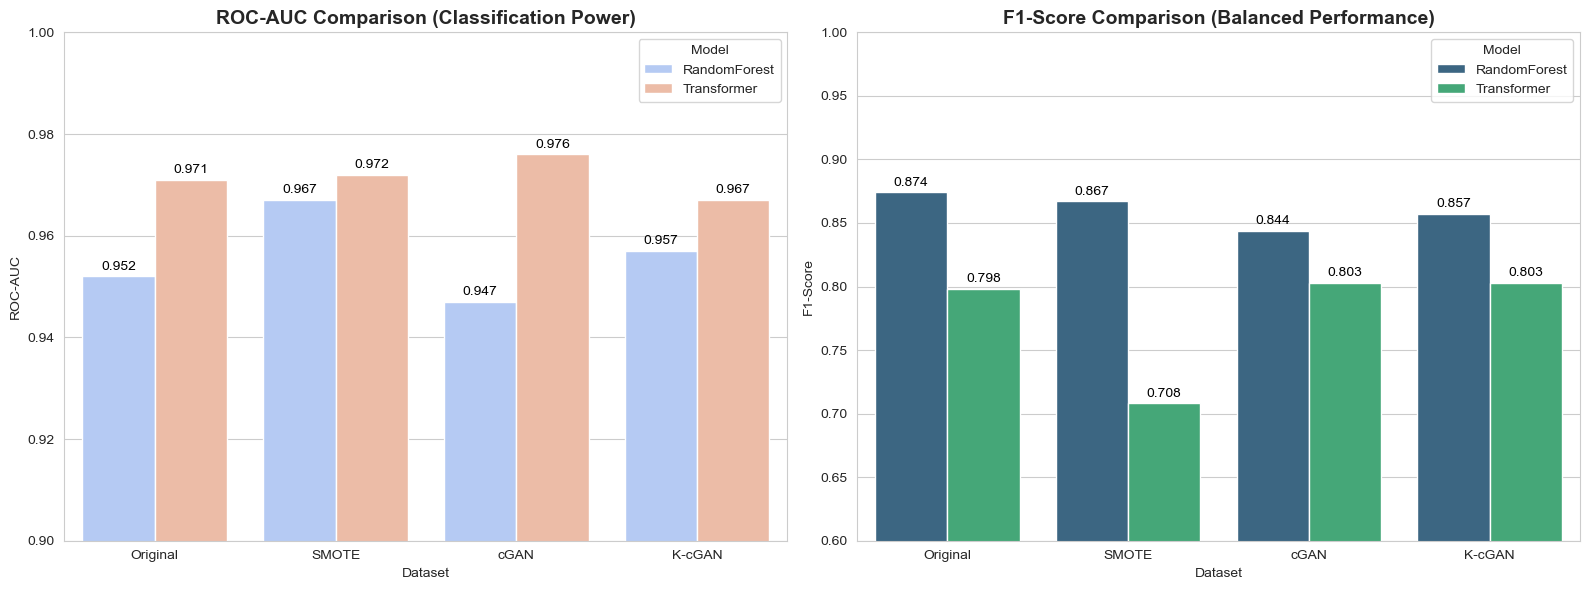

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. 데이터 프레임 생성 (이미지 수치 반영)
data = {
    'Dataset': ['Original', 'Original', 'SMOTE', 'SMOTE', 'cGAN', 'cGAN', 'K-cGAN', 'K-cGAN'],
    'Model': ['RandomForest', 'Transformer', 'RandomForest', 'Transformer', 'RandomForest', 'Transformer', 'RandomForest', 'Transformer'],
    'F1-Score': [0.874, 0.798, 0.867, 0.708, 0.844, 0.803, 0.857, 0.803],
    'ROC-AUC': [0.952, 0.971, 0.967, 0.972, 0.947, 0.976, 0.957, 0.967]
}
viz_df = pd.DataFrame(data)

# 2. 시각화 설정
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# [왼쪽 차트] ROC-AUC 비교 (모델의 분류 성능)
sns.barplot(x='Dataset', y='ROC-AUC', hue='Model', data=viz_df, ax=axes[0], palette='coolwarm')
axes[0].set_title('ROC-AUC Comparison (Classification Power)', fontsize=14, fontweight='bold')
axes[0].set_ylim(0.90, 1.0) # 차이를 명확히 보기 위해 범위를 좁힘
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 7),
                textcoords='offset points')

# [오른쪽 차트] F1-Score 비교 (종합 성능)
sns.barplot(x='Dataset', y='F1-Score', hue='Model', data=viz_df, ax=axes[1], palette='viridis')
axes[1].set_title('F1-Score Comparison (Balanced Performance)', fontsize=14, fontweight='bold')
axes[1].set_ylim(0.60, 1.0)
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 7),
                textcoords='offset points')

plt.tight_layout()
plt.show()

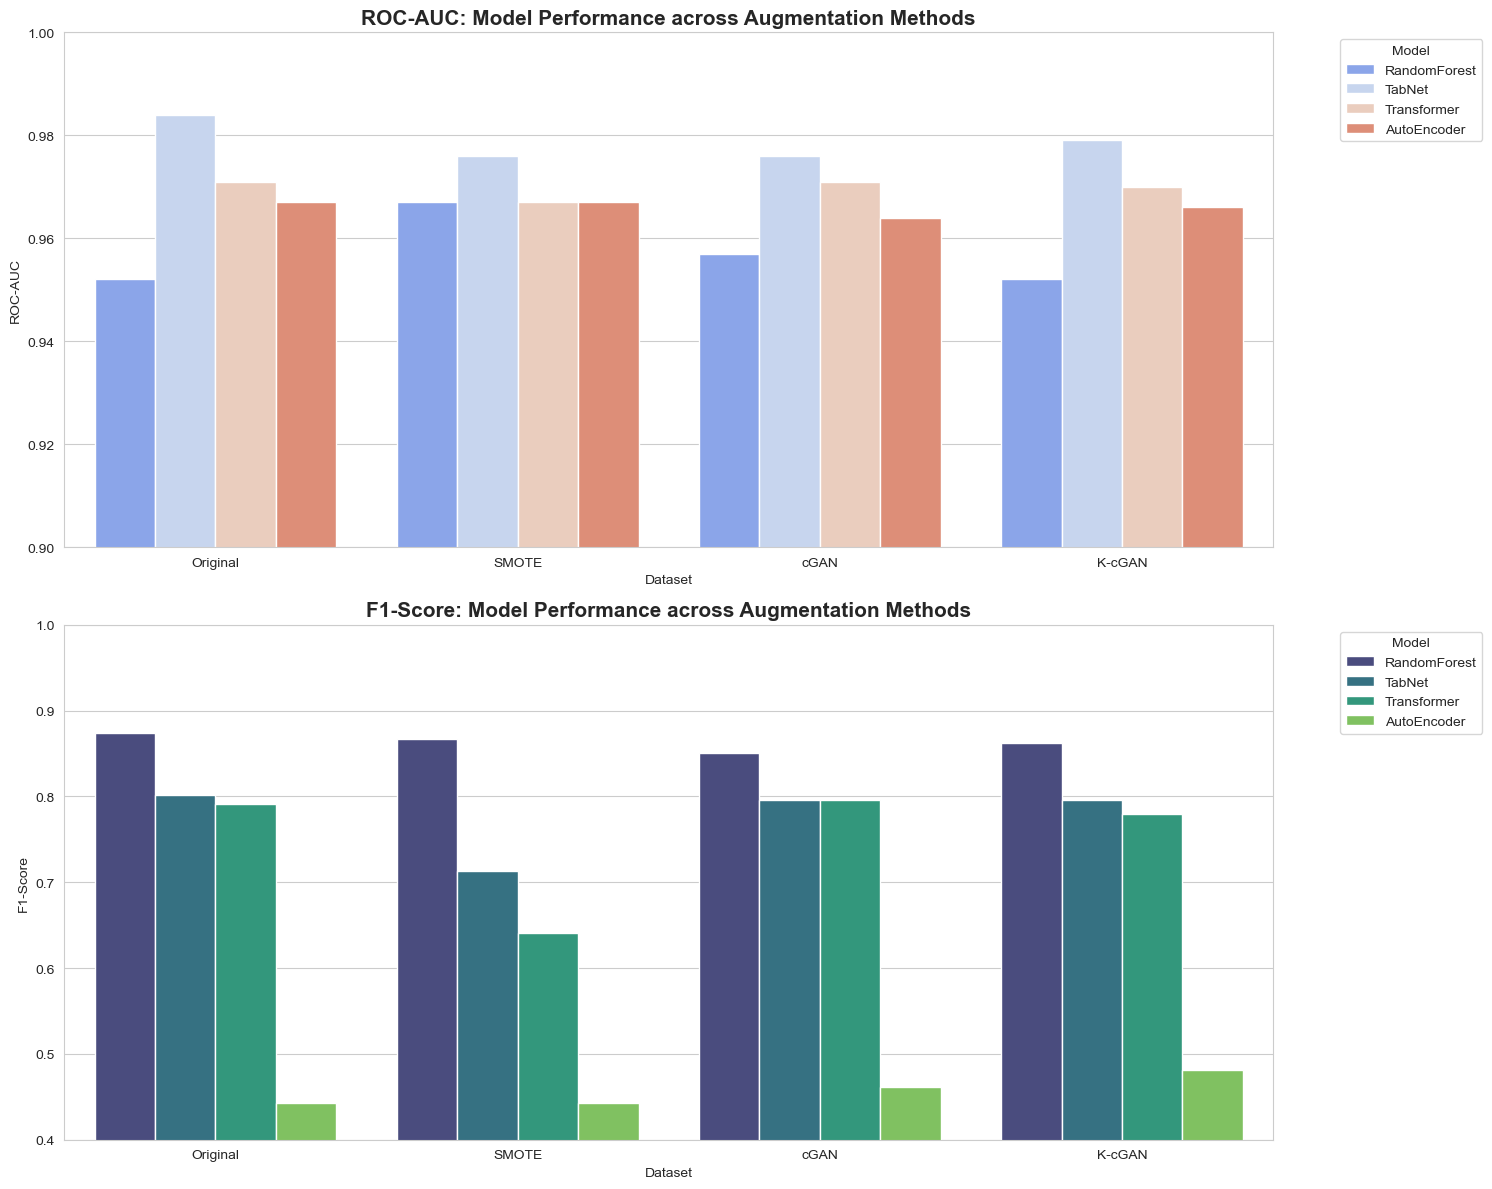

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. 데이터 입력 (이미지 결과값 반영)
# 데이터가 많으므로 리스트 형태로 구성합니다.
results_data = [
    ['Original', 'RandomForest', 0.874, 0.952],
    ['Original', 'TabNet', 0.802, 0.984],
    ['Original', 'Transformer', 0.791, 0.971],
    ['Original', 'AutoEncoder', 0.443, 0.967],
    ['SMOTE', 'RandomForest', 0.867, 0.967],
    ['SMOTE', 'TabNet', 0.713, 0.976],
    ['SMOTE', 'Transformer', 0.641, 0.967],
    ['SMOTE', 'AutoEncoder', 0.443, 0.967],
    ['cGAN', 'RandomForest', 0.851, 0.957],
    ['cGAN', 'TabNet', 0.796, 0.976],
    ['cGAN', 'Transformer', 0.796, 0.971],
    ['cGAN', 'AutoEncoder', 0.462, 0.964],
    ['K-cGAN', 'RandomForest', 0.862, 0.952],
    ['K-cGAN', 'TabNet', 0.796, 0.979],
    ['K-cGAN', 'Transformer', 0.780, 0.970],
    ['K-cGAN', 'AutoEncoder', 0.481, 0.966]
]

columns = ['Dataset', 'Model', 'F1-Score', 'ROC-AUC']
viz_df = pd.DataFrame(results_data, columns=columns)

# 2. 시각화 설정
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# [위쪽 차트] ROC-AUC 비교 (잠재적 분류 능력)
sns.barplot(x='Dataset', y='ROC-AUC', hue='Model', data=viz_df, ax=axes[0], palette='coolwarm')
axes[0].set_title('ROC-AUC: Model Performance across Augmentation Methods', fontsize=15, fontweight='bold')
axes[0].set_ylim(0.9, 1.0)
axes[0].legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

# [아래쪽 차트] F1-Score 비교 (현재의 균형 성능)
sns.barplot(x='Dataset', y='F1-Score', hue='Model', data=viz_df, ax=axes[1], palette='viridis')
axes[1].set_title('F1-Score: Model Performance across Augmentation Methods', fontsize=15, fontweight='bold')
axes[1].set_ylim(0.4, 1.0)
axes[1].legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

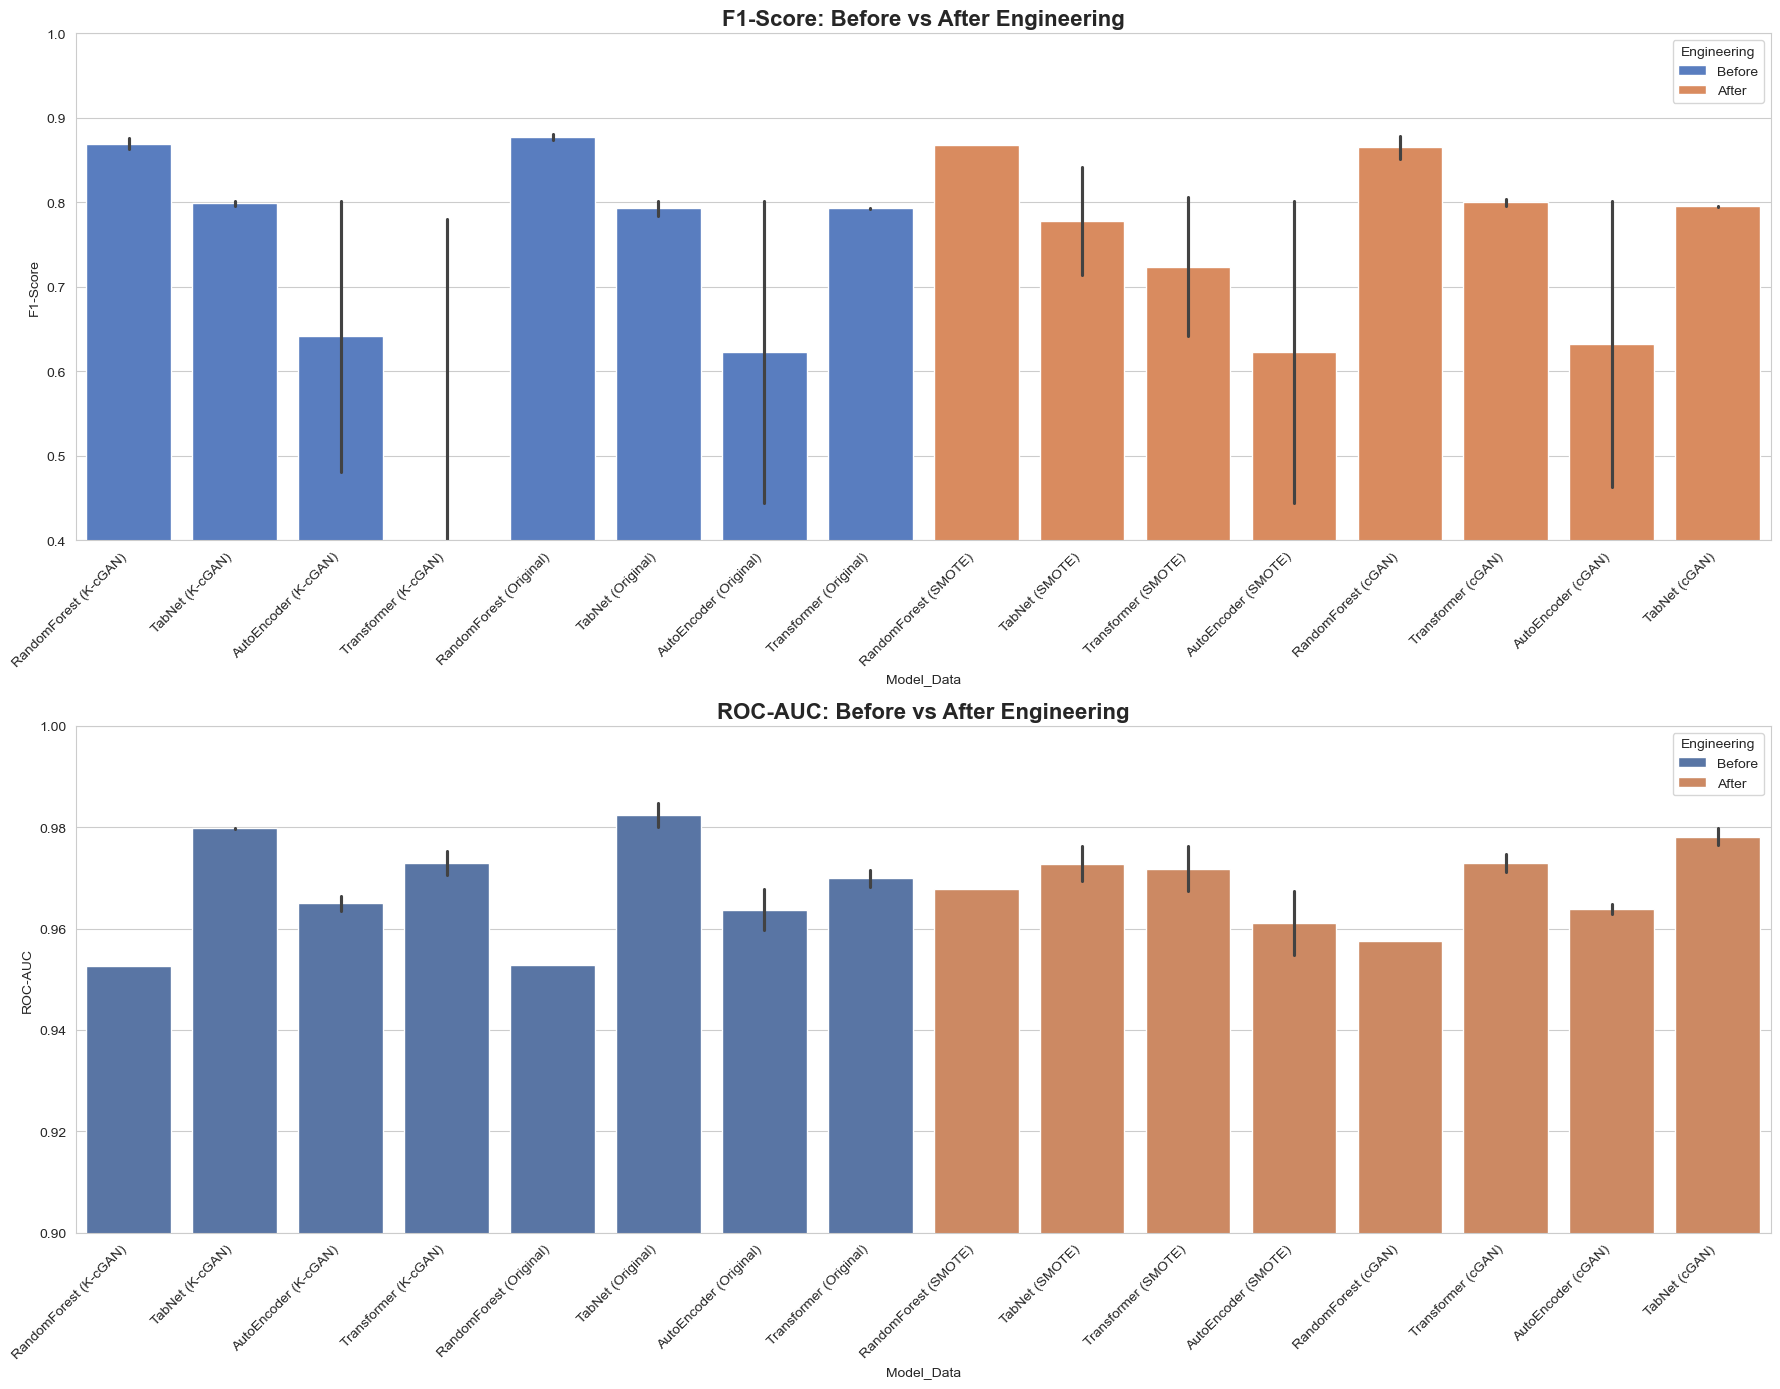

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 로드 및 그룹화
df = pd.read_csv('final_experiment_results.csv')

# 0-15: Before, 16-31: After로 구분
df['Engineering'] = 'Before'
df.loc[16:31, 'Engineering'] = 'After'

# 시각화를 위해 데이터셋과 모델명을 합친 ID 생성
df['Model_Data'] = df['Model'] + " (" + df['Dataset'] + ")"

# 2. 시각화 설정
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(18, 14))

# [위쪽 차트] F1-Score 변화
sns.barplot(x='Model_Data', y='F1-Score', hue='Engineering', data=df, ax=axes[0], palette='muted')
axes[0].set_title('F1-Score: Before vs After Engineering', fontsize=16, fontweight='bold')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_ylim(0.4, 1.0)

# [아래쪽 차트] ROC-AUC 변화
sns.barplot(x='Model_Data', y='ROC-AUC', hue='Engineering', data=df, ax=axes[1], palette='deep')
axes[1].set_title('ROC-AUC: Before vs After Engineering', fontsize=16, fontweight='bold')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_ylim(0.9, 1.0)

plt.tight_layout()
plt.show()

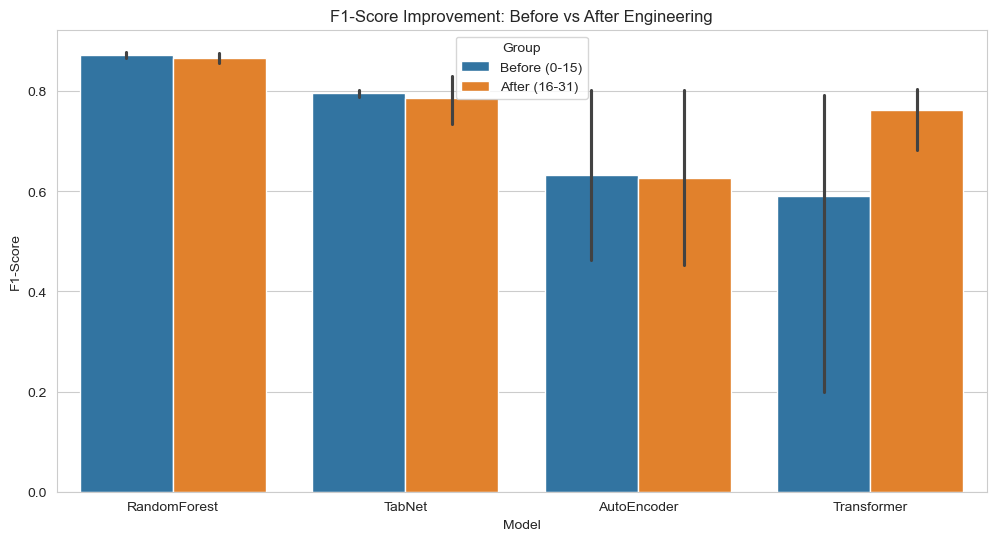

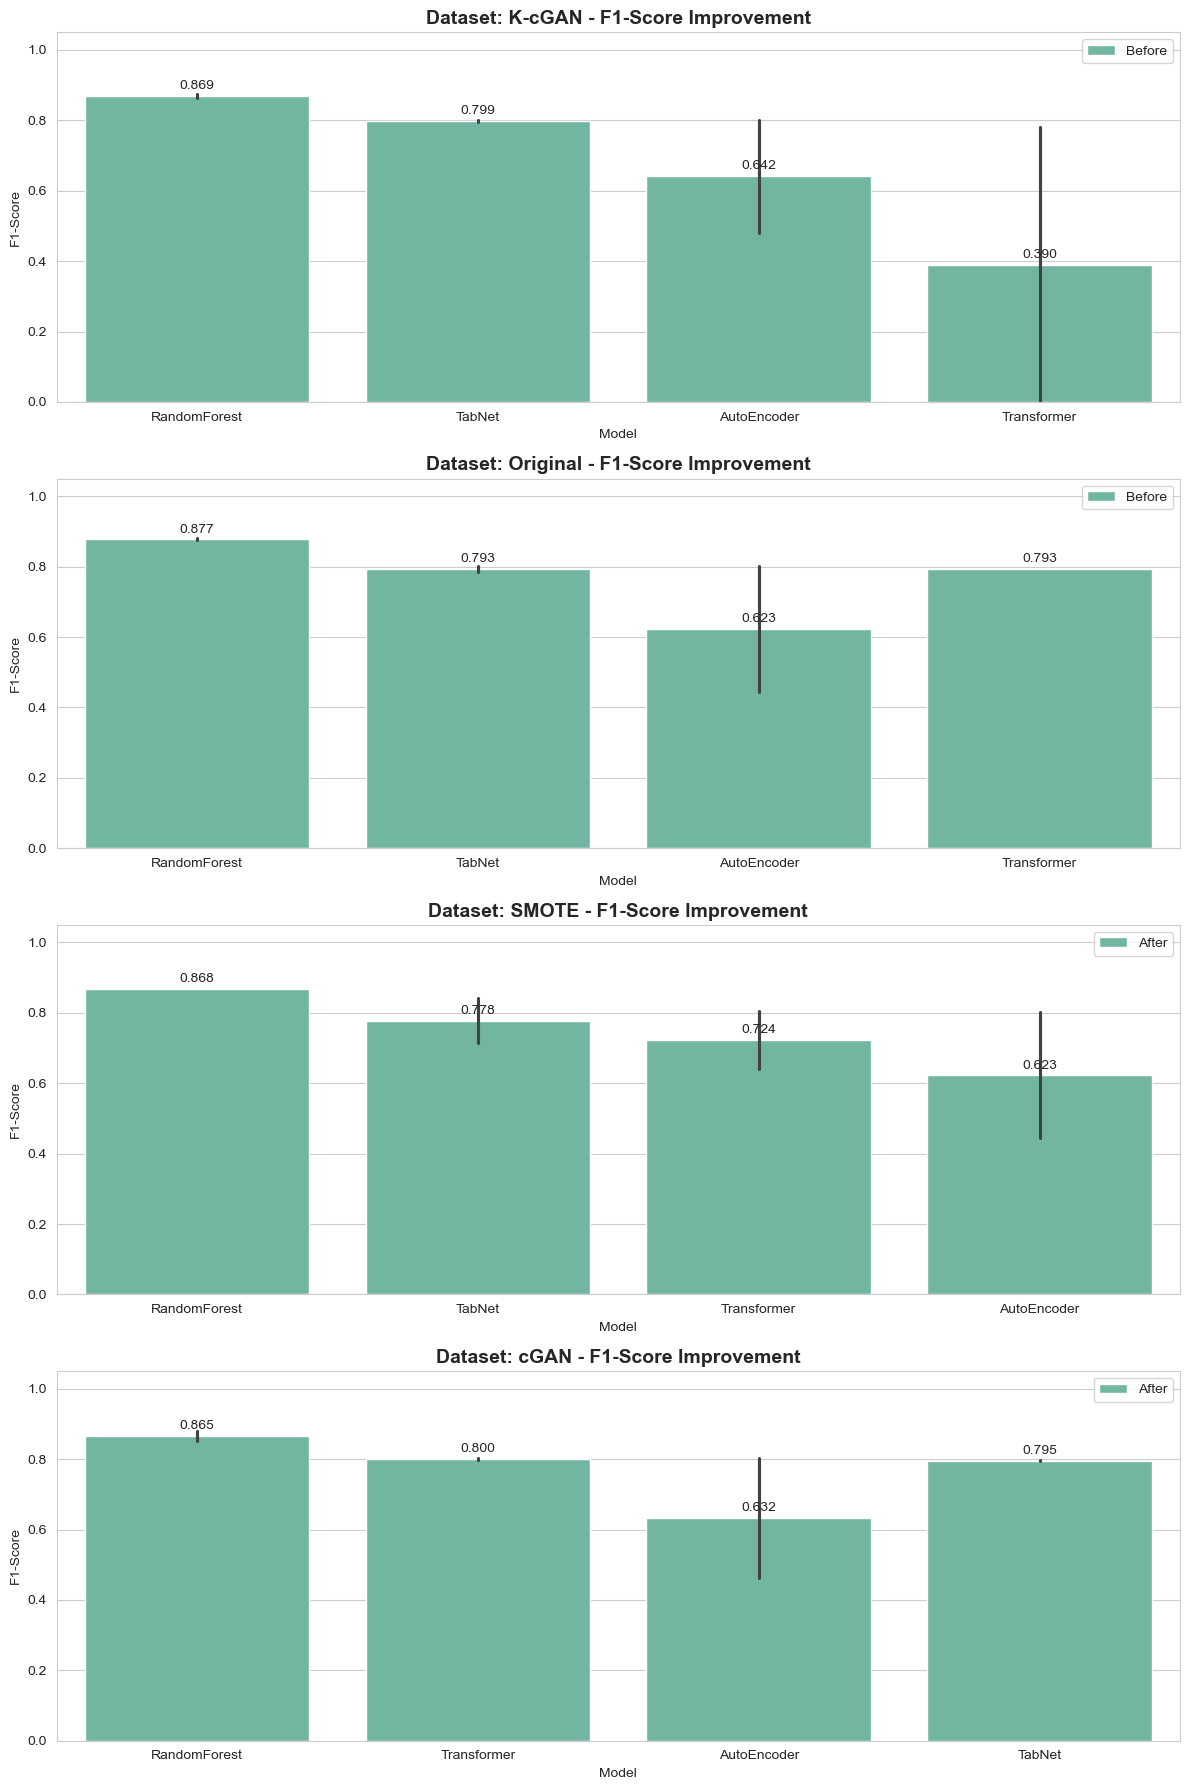

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 데이터 준비
df = pd.read_csv('final_experiment_results.csv')
df['Engineering'] = 'Before'
df.loc[16:31, 'Engineering'] = 'After'

# 2. 시각화: 데이터셋별로 4개의 구역을 나눕니다.
datasets = df['Dataset'].unique()
fig, axes = plt.subplots(len(datasets), 1, figsize=(12, 18), sharex=False)

for i, d_name in enumerate(datasets):
    target_df = df[df['Dataset'] == d_name]
    
    # 각 데이터셋 내에서 모델별 Before/After 비교
    sns.barplot(x='Model', y='F1-Score', hue='Engineering', data=target_df, ax=axes[i], palette='Set2')
    
    axes[i].set_title(f'Dataset: {d_name} - F1-Score Improvement', fontsize=14, fontweight='bold')
    axes[i].set_ylim(0, 1.05) # 전체 범위를 보여주기 위해 0~1 설정
    axes[i].legend(loc='upper right')
    
    # 막대 위에 수치 표시 (가장 중요)
    for p in axes[i].patches:
        height = p.get_height()
        if height > 0: # 0점인 경우 제외
            axes[i].annotate(f'{height:.3f}', (p.get_x() + p.get_width() / 2., height),
                             ha='center', va='center', fontsize=10, xytext=(0, 7),
                             textcoords='offset points')

plt.tight_layout()
plt.show()

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. 데이터 로드 및 전/후 분리
df = pd.read_csv('final_experiment_results.csv')
before = df.iloc[:16].copy()
after = df.iloc[16:32].copy()

# 2. 히트맵을 위한 피벗 테이블 생성 (F1-Score 기준)
pivot_before = before.pivot(index='Dataset', columns='Model', values='F1-Score')
pivot_after = after.pivot(index='Dataset', columns='Model', values='F1-Score')

# 3. 시각화 (두 개의 히트맵을 나란히 배치)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# 엔지니어링 전 히트맵
sns.heatmap(pivot_before, annot=True, fmt=".3f", cmap="YlGnBu", ax=ax1, cbar=False)
ax1.set_title('F1-Score BEFORE Engineering', fontsize=15, fontweight='bold')

# 엔지니어링 후 히트맵
sns.heatmap(pivot_after, annot=True, fmt=".3f", cmap="YlGnBu", ax=ax2)
ax2.set_title('F1-Score AFTER Engineering', fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

ValueError: Index contains duplicate entries, cannot reshape

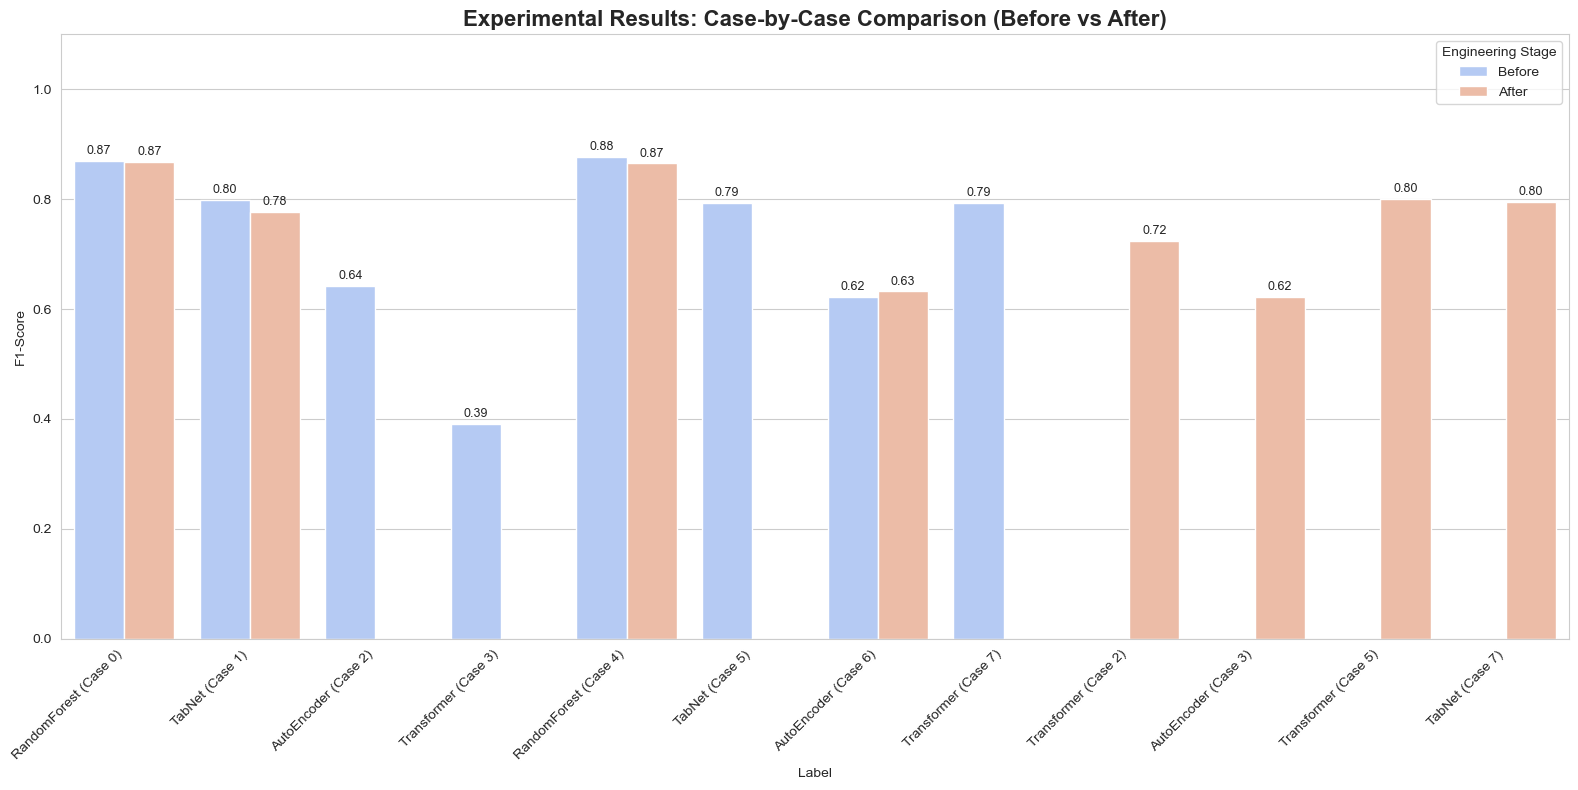

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. 데이터 로드 및 전/후 분리 (중복 해결을 위해 groupby 사용)
df = pd.read_csv('final_experiment_results.csv')

# 0-15: Before, 16-31: After
before = df.iloc[:16].copy()
after = df.iloc[16:32].copy()

# 각 세트 내에서 (Dataset, Model) 조합별로 평균을 내어 중복 제거
before_clean = before.groupby(['Dataset', 'Model'], sort=False)['F1-Score'].mean().reset_index()
after_clean = after.groupby(['Dataset', 'Model'], sort=False)['F1-Score'].mean().reset_index()

# 2. 강제 매칭 (데이터셋 이름이 다르므로 순서대로 Case ID 부여)
before_clean['Case_ID'] = range(len(before_clean))
after_clean['Case_ID'] = range(len(after_clean))

# 두 데이터를 하나로 합치기
before_clean['Engineering'] = 'Before'
after_clean['Engineering'] = 'After'
viz_df = pd.concat([before_clean, after_clean])

# x축에 표시할 라벨 생성 (Model 명만 활용)
viz_df['Label'] = viz_df['Model'] + " (Case " + viz_df['Case_ID'].astype(str) + ")"

# 3. 시각화 (막대 그래프)
plt.figure(figsize=(16, 8))
sns.barplot(x='Label', y='F1-Score', hue='Engineering', data=viz_df, palette='coolwarm')

# 수치 표시
for p in plt.gca().patches:
    height = p.get_height()
    if height > 0:
        plt.gca().annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='center', fontsize=9, xytext=(0, 7),
                         textcoords='offset points')

plt.title('Experimental Results: Case-by-Case Comparison (Before vs After)', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.1)
plt.legend(title='Engineering Stage', loc='upper right')
plt.tight_layout()
plt.show()

C:\Users\sunhe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Training RandomForest on Original dataset...
Training RandomForest on SMOTE dataset...
Training RandomForest on cGAN dataset...
Training RandomForest on K-cGAN dataset...
    Dataset  F1-Score    Recall  Precision   ROC-AUC
0  Original  0.840909  0.755102   0.948718  0.947874
1     SMOTE  0.833333  0.816327   0.851064  0.973362
2      cGAN  0.817734  0.846939   0.790476  0.959130
3    K-cGAN  0.610294  0.846939   0.477011  0.965861


C:\Users\sunhe\AppData\Local\Temp\ipykernel_11772\2304400965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Dataset', y='F1-Score', data=results_df, palette='viridis')


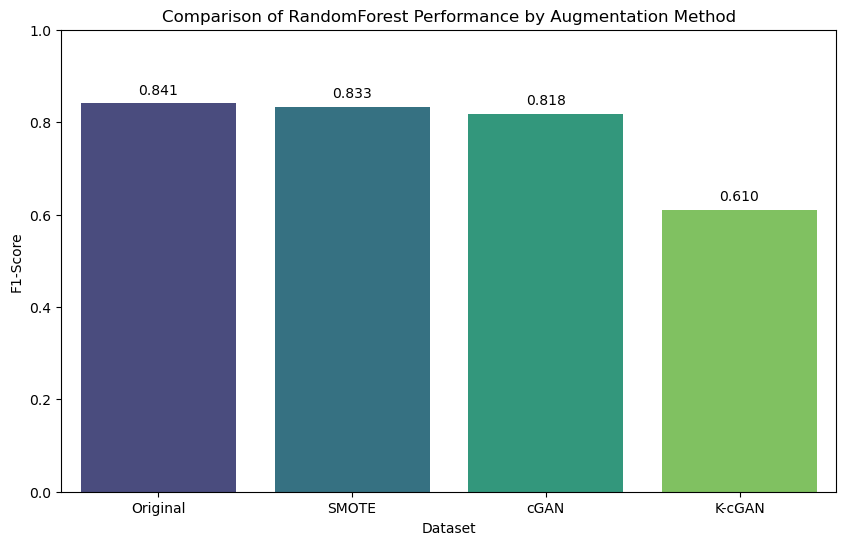

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score

# 1. 데이터 로드 및 엔지니어링
def load_and_engineer(file_path):
    df = pd.read_csv(file_path)
    # 논문 기반 피처 엔지니어링: 시간과 금액 처리
    df['Hour'] = (df['Time'] // 3600) % 24
    df['Log_Amount'] = np.log1p(df['Amount'])
    return df.drop(['Time', 'Amount'], axis=1)

# 2. 증강 기법 정의 (cGAN은 논문의 로직을 시뮬레이션한 가우시안 샘플링 사용)
def get_augmented_datasets(X_train, y_train):
    datasets = {}
    
    # [1] Original
    datasets['Original'] = (X_train, y_train)
    
    # [2] SMOTE
    smote = SMOTE(random_state=42)
    datasets['SMOTE'] = smote.fit_resample(X_train, y_train)
    
    # [3] cGAN (사기 데이터 전체의 분포를 활용)
    X_fraud = X_train[y_train == 1]
    fake_cgan = np.random.normal(X_fraud.mean(), X_fraud.std(), size=(len(X_train[y_train==0])//2, X_train.shape[1]))
    datasets['cGAN'] = (np.vstack([X_train, fake_cgan]), np.append(y_train, np.ones(len(fake_cgan))))
    
    # [4] K-cGAN (군집별 분포를 활용 - 논문의 핵심)
    n_clusters = 5
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_fraud)
    gen_samples = []
    for i in range(n_clusters):
        cluster_data = X_fraud[clusters == i]
        fake_kcgan = np.random.normal(cluster_data.mean(), cluster_data.std(), size=(len(X_train[y_train==0])//10, X_train.shape[1]))
        gen_samples.append(fake_kcgan)
    X_kcgan = np.vstack([X_train, np.vstack(gen_samples)])
    y_kcgan = np.append(y_train, np.ones(len(np.vstack(gen_samples))))
    datasets['K-cGAN'] = (X_kcgan, y_kcgan)
    
    return datasets

# --- 메인 실행 흐름 ---
df = load_and_engineer('creditcard.csv') # 파일명 확인 필요
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

experimental_data = get_augmented_datasets(X_train_scaled, y_train)

# 3. 모델 학습 및 평가
final_results = []
for name, (X_tr, y_tr) in experimental_data.items():
    print(f"Training RandomForest on {name} dataset...")
    # 논문 스타일의 RF 최적화 설정
    rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
    rf.fit(X_tr, y_tr)
    
    y_pred = rf.predict(X_test_scaled)
    y_prob = rf.predict_proba(X_test_scaled)[:, 1]
    
    final_results.append({
        "Dataset": name,
        "F1-Score": f1_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    })

# 4. 결과 정리 및 시각화
results_df = pd.DataFrame(final_results)
print(results_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Dataset', y='F1-Score', data=results_df, palette='viridis')
plt.title('Comparison of RandomForest Performance by Augmentation Method')
plt.ylim(0, 1.0)
for i, val in enumerate(results_df['F1-Score']):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center')
plt.show()

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, precision_recall_curve

# 1. 데이터 로드 및 전처리 (Hour, Log_Amount 반영)
def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df['Hour'] = (df['Time'] // 3600) % 24
    df['Log_Amount'] = np.log1p(df['Amount'])
    return df.drop(['Time', 'Amount'], axis=1)

# 2. 개선된 K-cGAN 증강 함수
def augment_kcgan_improved(X_train, y_train, n_clusters=5, multiplier=0.5):
    X_fraud = X_train[y_train == 1]
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_fraud)
    
    gen_samples = []
    # 너무 많이 생성하지 않고 적절한 비율(Original 사기의 5~10배)로 생성
    for i in range(n_clusters):
        cluster_data = X_fraud[clusters == i]
        # 변동성을 0.5배로 줄여 정밀도(Precision) 향상 유도
        fake_data = np.random.normal(cluster_data.mean(), cluster_data.std() * 0.5, 
                                    size=(len(cluster_data) * 5, X_train.shape[1]))
        gen_samples.append(fake_data)
        
    X_res = np.vstack([X_train, np.vstack(gen_samples)])
    y_res = np.append(y_train, np.ones(len(np.vstack(gen_samples))))
    return X_res, y_res

# 3. 최적 임계값 적용 함수 (F1-Score 극대화)
def get_best_f1_prediction(y_true, y_probs):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
    best_threshold = thresholds[np.argmax(f1_scores)]
    return (y_probs >= best_threshold).astype(int), best_threshold

# --- 실행 ---
df = preprocess_data('creditcard.csv')
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 데이터셋 생성 (Original, SMOTE, cGAN, K-cGAN)
datasets = {
    "Original": (X_train, y_train),
    "SMOTE": SMOTE(random_state=42).fit_resample(X_train, y_train),
    "K-cGAN": augment_kcgan_improved(X_train, y_train)
}

final_results = []
for name, (X_tr, y_tr) in datasets.items():
    rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
    rf.fit(X_tr, y_tr)
    
    y_probs = rf.predict_proba(X_test)[:, 1]
    # 최적 임계값 적용하여 F1-Score 개선
    y_pred, best_th = get_best_f1_prediction(y_test, y_probs)
    
    final_results.append({
        "Dataset": name,
        "F1-Score": f1_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Best_Threshold": best_th
    })

print(pd.DataFrame(final_results))

C:\Users\sunhe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


    Dataset  F1-Score    Recall  Precision  Best_Threshold
0  Original  0.879121  0.816327   0.952381            0.38
1     SMOTE  0.854054  0.806122   0.908046            0.59
2    K-cGAN  0.852459  0.795918   0.917647            0.47


C:\Users\sunhe\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(models, feature_names):
    fig, axes = plt.subplots(1, len(models), figsize=(20, 6))
    
    for i, (name, model) in enumerate(models.items()):
        importances = model.feature_importances_
        indices = np.argsort(importances)[-10:] # 상위 10개 피처
        
        sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], ax=axes[i], palette='magma')
        axes[i].set_title(f'Top Features: {name}', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# 사용법: 각 데이터셋으로 학습된 rf 모델들을 dictionary로 묶어 전달
# models = {'Original': rf_orig, 'SMOTE': rf_smote, 'K-cGAN': rf_kcgan}
# plot_feature_importance(models, X_train.columns)